In [ ]:
%reset -f

In [ ]:
# Set to false if working on local env
onColab = True

model_path = './e2d2'

# Decide batch size and validation split
batch_size = 128
validation_split = 0.2
test_split = 0.05
epochs = 200

dataset_path = './Training.csv'

window = 600
stride = 10
# 864 / 16
telescope = 108

In [ ]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2
e1d1  e1d1.ipynb  e2d2.ipynb  model.png  test2	Training.csv


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


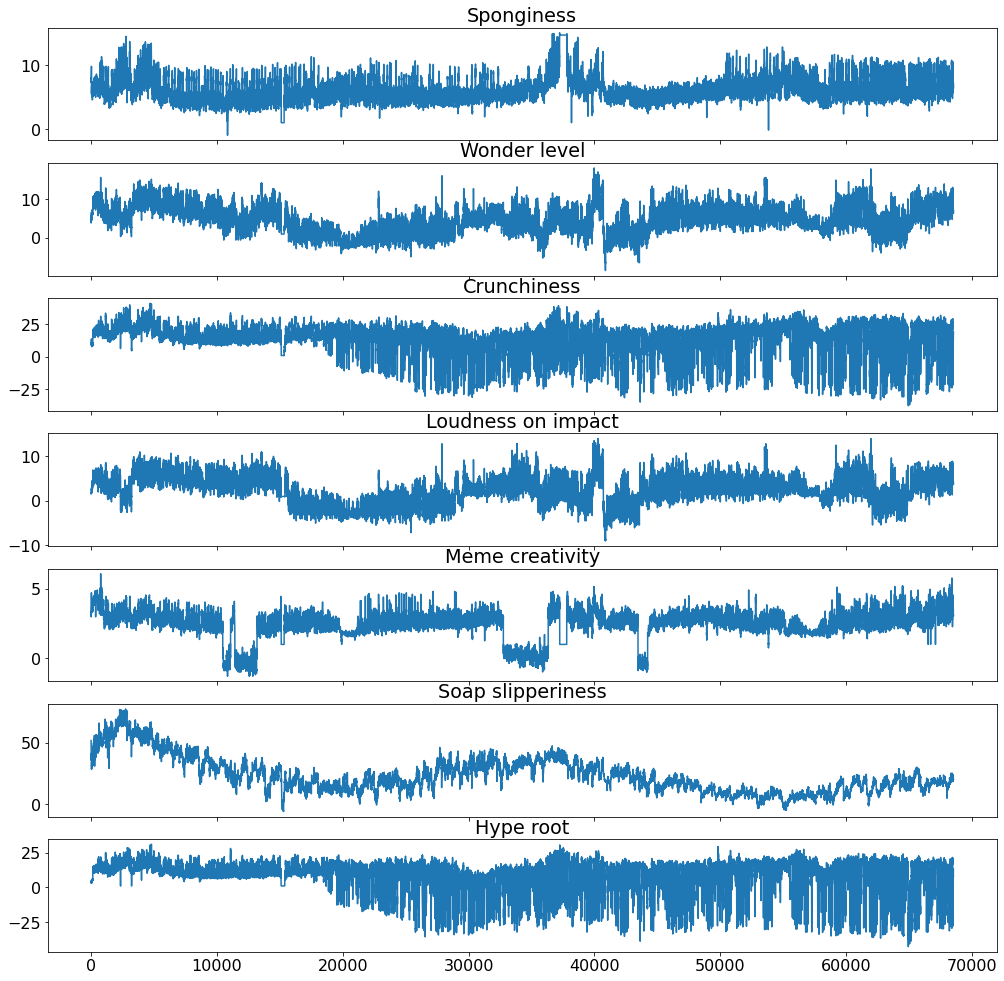

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [ ]:
test_size = round(dataset.shape[0] * test_split)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


(65102, 7) (3426, 7)


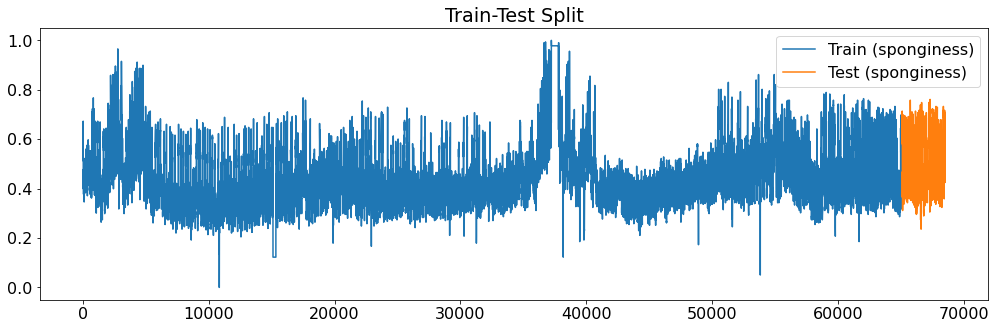

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 600, 7)

In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
target_labels = dataset.columns

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6470, 600, 7), (6470, 108, 7), (290, 600, 7), (290, 108, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

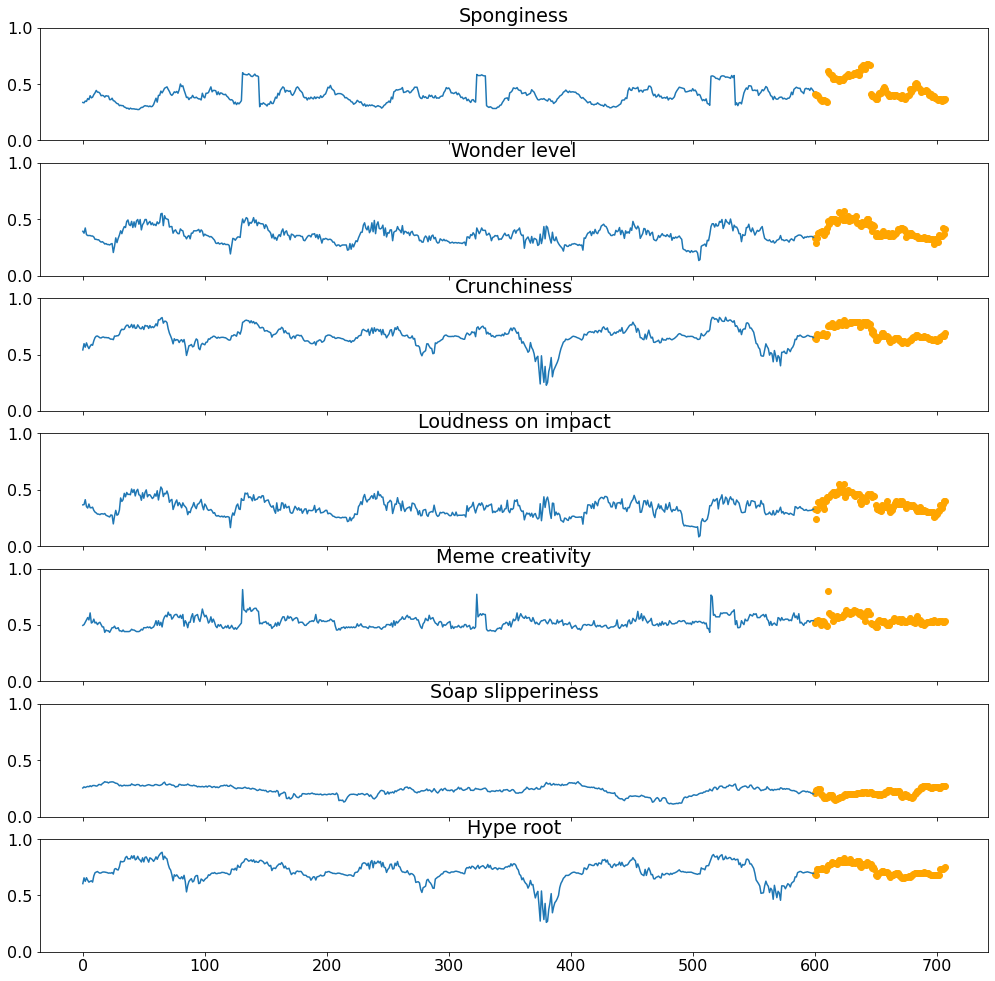

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape


((600, 7), (108, 7))

In [ ]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]
    # E2D2
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
    #
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
    model_e2d2.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e2d2

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 600, 7)]     0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 600, 100),   43200       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_5 (LSTM)                  [(None, 100),        80400       ['lstm_4[0][0]']                 
                                 (None, 100),                                               

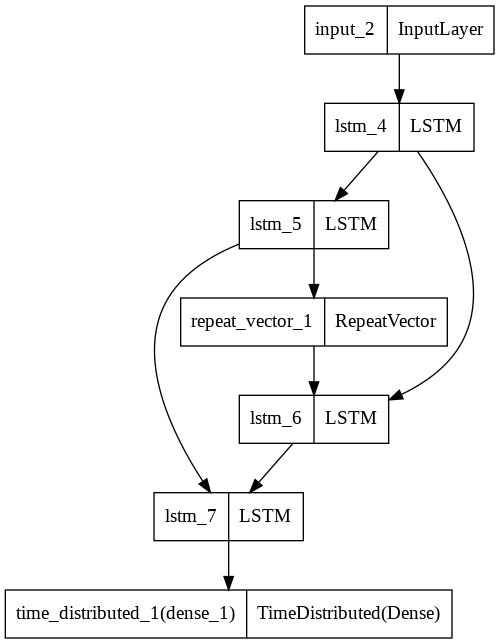

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        # tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
41/41 [==============================] - 24s 347ms/step - loss: 0.0425 - mae: 0.1478 - val_loss: 0.0230 - val_mae: 0.1165 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 12s 303ms/step - loss: 0.0132 - mae: 0.0849 - val_loss: 0.0160 - val_mae: 0.0889 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 12s 304ms/step - loss: 0.0102 - mae: 0.0715 - val_loss: 0.0154 - val_mae: 0.0867 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 12s 303ms/step - loss: 0.0096 - mae: 0.0697 - val_loss: 0.0144 - val_mae: 0.0829 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 12s 302ms/step - loss: 0.0093 - mae: 0.0684 - val_loss: 0.0140 - val_mae: 0.0805 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 12s 302ms/step - loss: 0.0091 - mae: 0.0680 - val_loss: 0.0139 - val_mae: 0.0813 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 12s 303ms/step - loss: 0.0089 - mae: 0.0675 - val_loss: 0.0139 - 

In [ ]:
model.save(model_path)

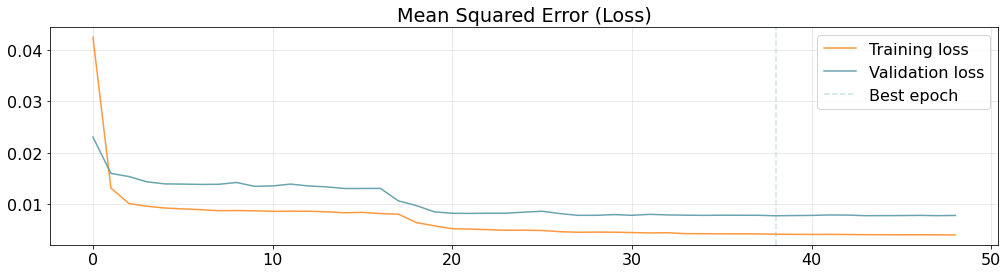

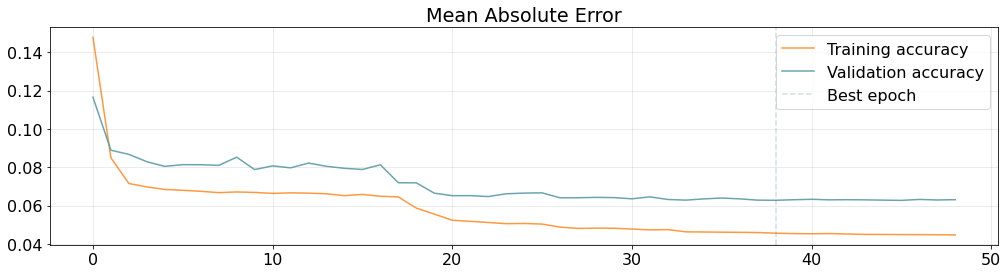

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# plt.figure(figsize=(18,3))
# plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

In [ ]:
# model = tfk.models.load_model(model_path)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(290, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0075191883>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.061172493>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

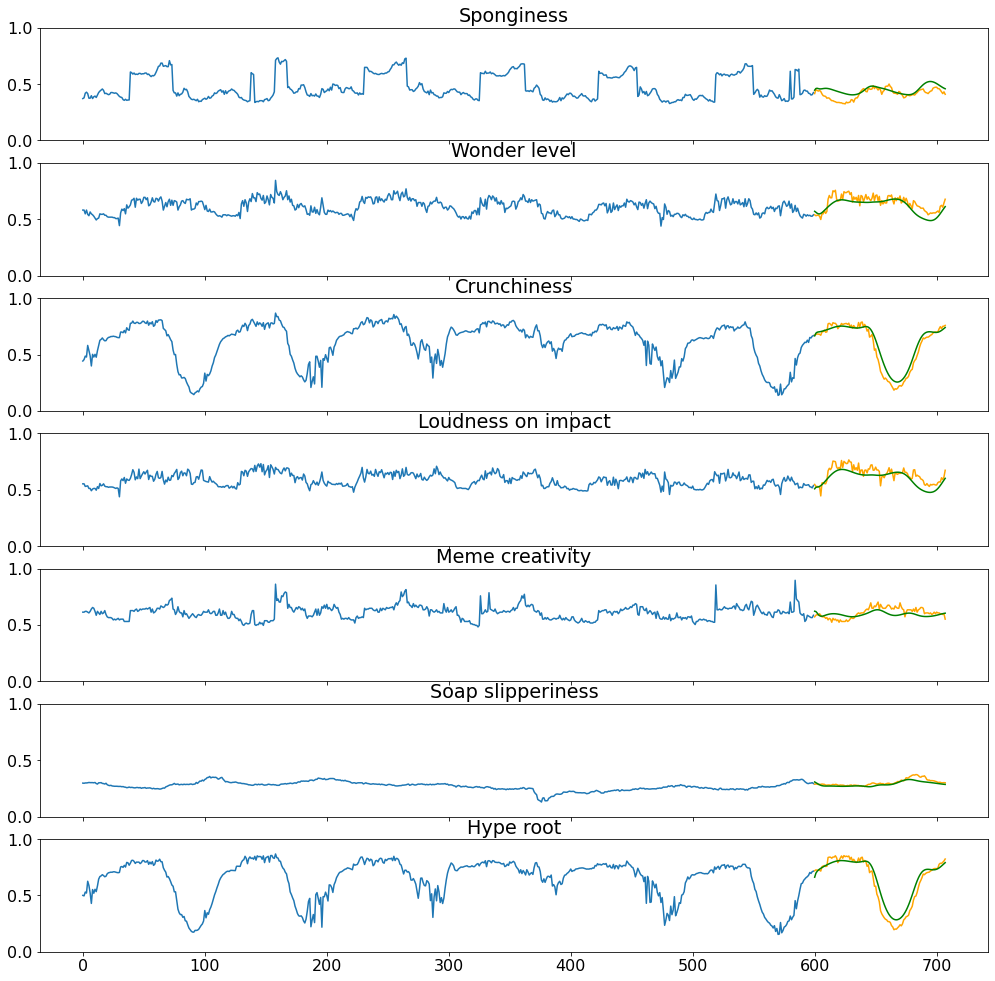

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

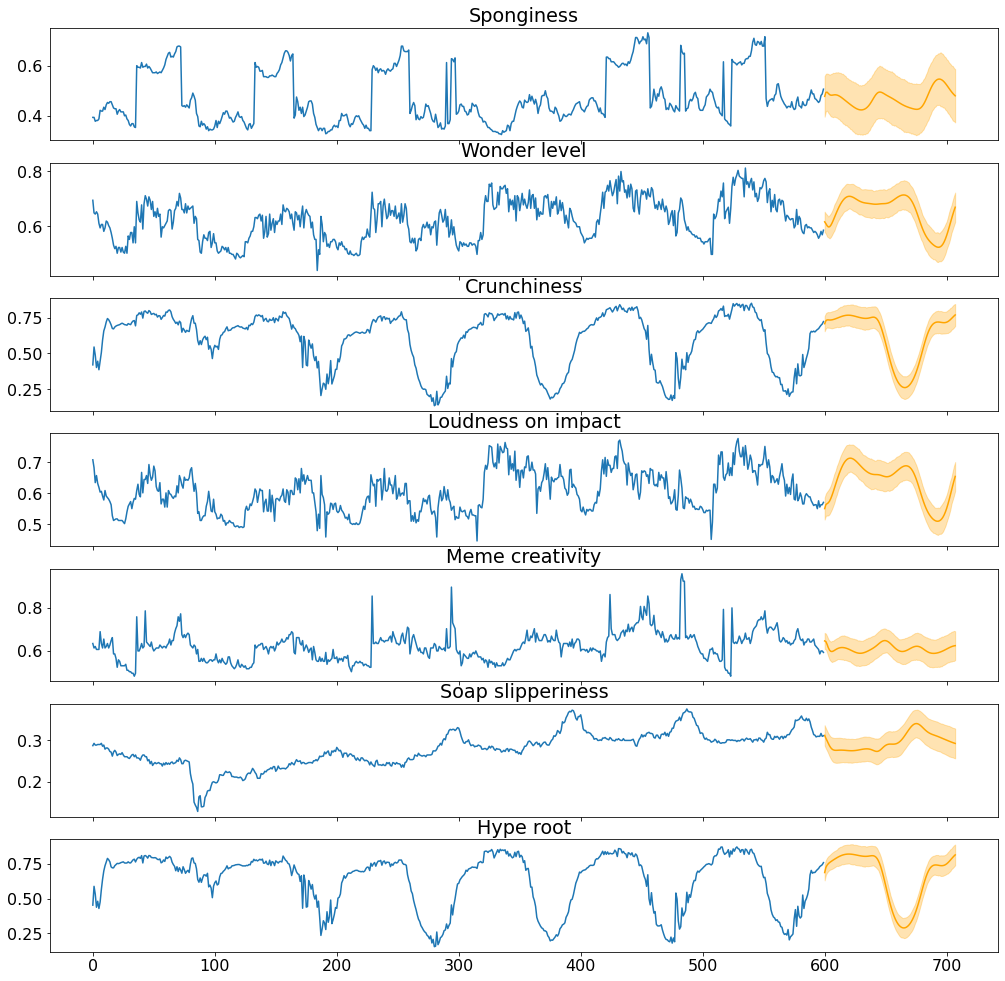

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((214, 600, 7), (214, 864, 7))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
avgwin = 3
X = X_test_reg
a = int(np.floor(avgwin / 2))
reg_predictions_averaged = np.zeros(shape=(reg_predictions.shape))
for i,x1 in enumerate(reg_predictions):
  for j,x2 in enumerate(x1.T):
    for k,x in enumerate(x2):
      if k < a:
        reg_predictions_averaged[i,k,j] = sum(np.concatenate((X[i,-(a - k) :,j], reg_predictions[i,: (a + k + 1),j])))/(avgwin)
      elif x2.size - k <= a:
        reg_predictions_averaged[i,k,j] = sum(reg_predictions[i,-(x2.size - k + a) :,j])/(reg_predictions[i,-(x2.size - k + a):,j].size)
      else:
        reg_predictions_averaged[i,k,j] = sum(reg_predictions[i,k - a : k + a + 1,j])/(avgwin)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.009582537>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07249361>)

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions_averaged.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions_averaged.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=0.009562330953071456>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.07242001168168437>)

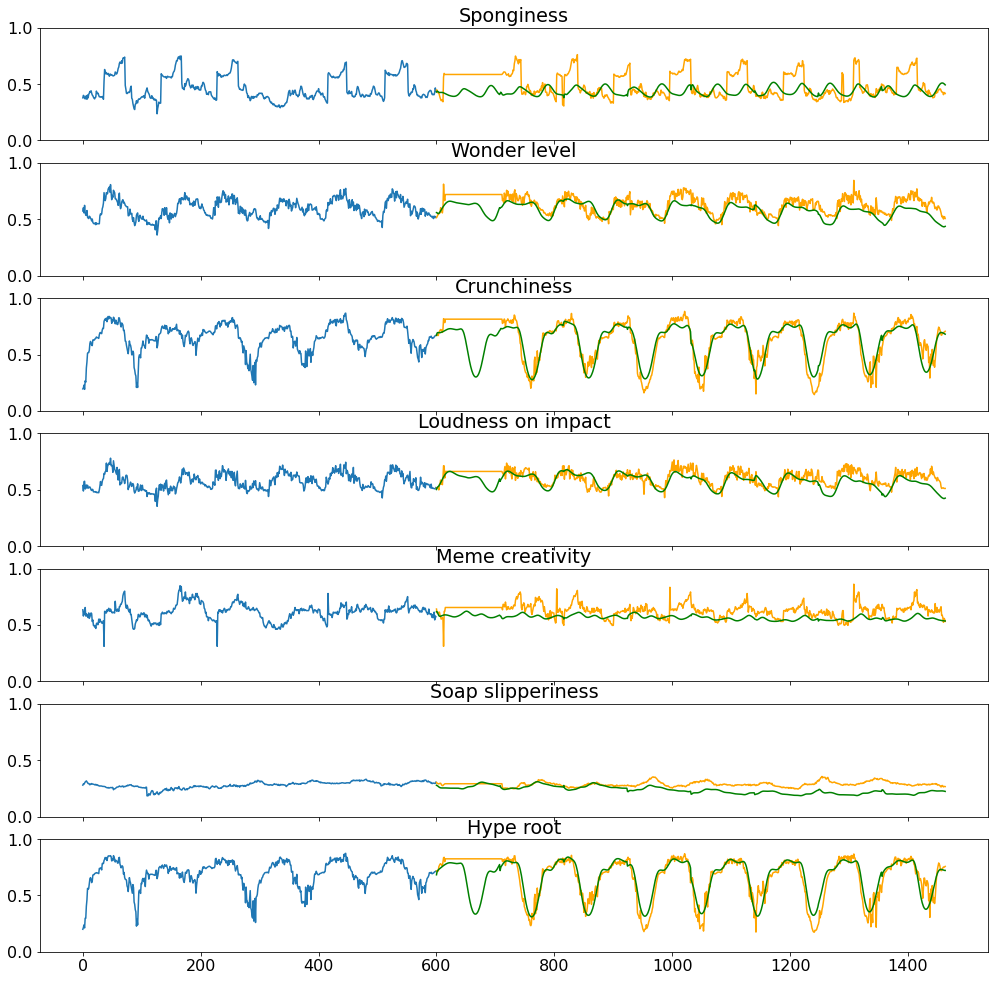

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

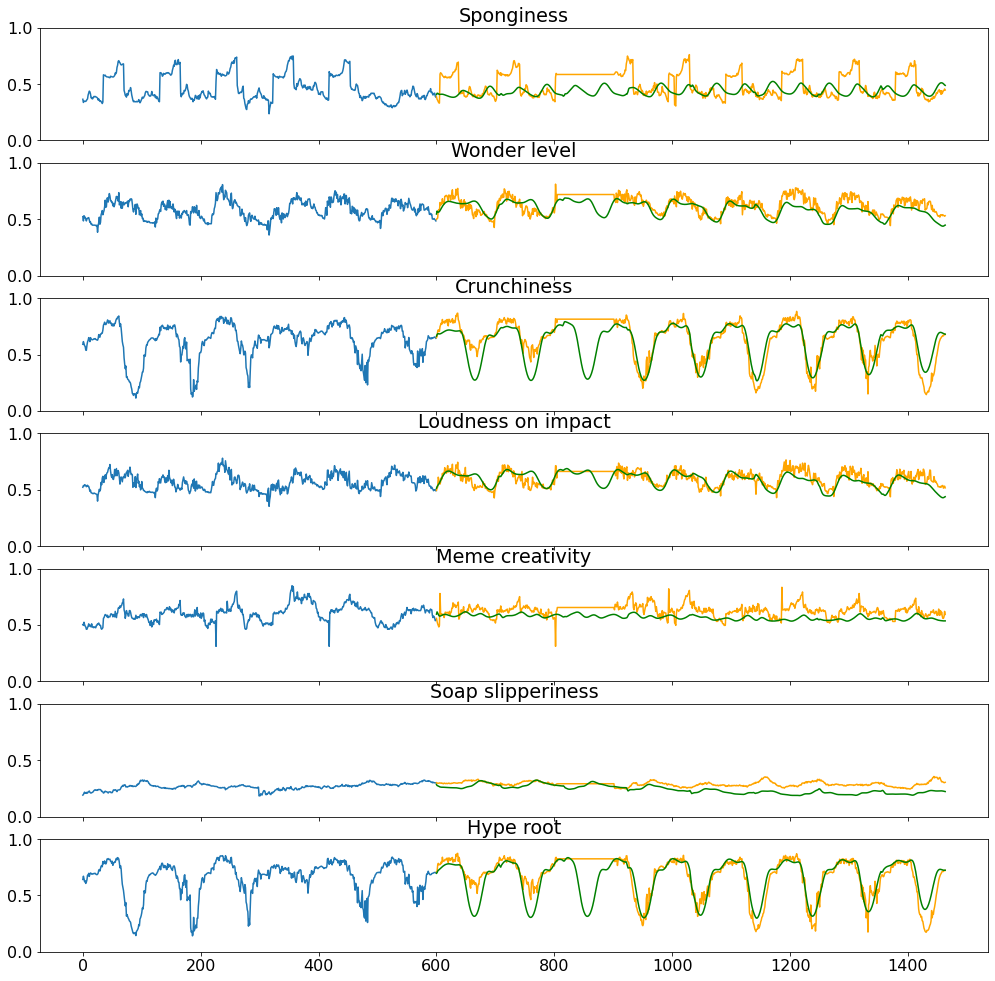

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions_averaged, target_labels, reg_telescope)